# Imports

In [6]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiPoint
from matplotlib import pyplot as plt
import fiona
import os
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data
import time
from geotiff import GeoTiff
from PIL import Image
import rasterio
import rasterio.plot
import rasterio.warp
from rasterio.crs import CRS
import openpyxl
import rasterio.features
# import georasters
import laspy
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import open3d as o3d
import scipy
import math
import random

# Code

### Read Files

In [24]:
ungulates = {}
for file in os.listdir('frames/'):
    gdf = gpd.read_file('frames/' + file)
    gdf.crs = 'EPSG:2180'
    ungulates.update({file[:-8] : gdf})

ERROR - 2023-06-25 19:59:33,087 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:33,217 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:33,323 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:33,422 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:33,605 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:33,717 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:33,832 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:33,936 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:34,037 - collection - PROJ: proj_create: no database context specified
ERROR - 2023-06-25 19:59:34,156 - collection - PROJ: proj_create: no database context specified


In [8]:
prunus = gpd.read_file('prunus_trees.geojson')

ERROR - 2023-06-25 19:55:27,758 - collection - PROJ: proj_create_from_database: /Users/sahil/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [9]:
dists = {}
for file in os.listdir('Distributions/Tree/'):
    dists.update({file[:-4] : pd.read_csv('Distributions/Tree/' + file)})

In [10]:
absencedists = {}
for file in os.listdir('Distributions/Absence/'):
    absencedists.update({file[:-4] : pd.read_csv('Distributions/Absence/' + file)})

### Data Analysis

##### Associations

In [ ]:
association = {}
for file in os.listdir('frames/'):
    name = file[:-8]
    species = ungulates[name].to_crs('EPSG:2180')
    arr = []
    for i in range(len(prunus)):
        scale = []
        tree = prunus.to_crs('EPSG:2180').iloc[i]
        treeX = tree['geometry'].x
        treeY = tree['geometry'].y
        remainderX = treeX - int (treeX/500)*500
        remainderY = treeY - int (treeY/500)*500
        lowlow = species.loc[species['x'] == treeX-remainderX].loc[species['y'] == treeY - remainderY]['Scale']
        lowhigh = species.loc[species['x'] == treeX-remainderX].loc[species['y'] == treeY - remainderY+500]['Scale']
        highlow = species.loc[species['x'] == treeX-remainderX+500].loc[species['y'] == treeY - remainderY]['Scale']
        highhigh = species.loc[species['x'] == treeX-remainderX+500].loc[species['y'] == treeY - remainderY+500]['Scale']
        if len(lowlow) > 0:
            scale.append(list(lowlow)[0])
        if len(lowhigh) > 0:
            scale.append(list(lowhigh)[0])
        if len(highlow) > 0:
            scale.append(list(highlow)[0])
        if len(highhigh) > 0:
            scale.append(list(highhigh)[0])
        if len(scale) > 0:
            arr.append(sum(scale)/len(scale))
    if len(arr) > 0:
        association.update({name : arr})

In [8]:
nullHyp = {}
for file in os.listdir('frames/'):
    name = file[:-8]
    species = ungulates[name].to_crs('EPSG:2180').copy()
    species['Scale'] = sum(species['Scale'])/len(species['Scale'])
    arr = []
    for i in range(len(prunus)):
        scale = []
        tree = prunus.to_crs('EPSG:2180').iloc[i]
        treeX = tree['geometry'].x
        treeY = tree['geometry'].y
        remainderX = treeX - int (treeX/500)*500
        remainderY = treeY - int (treeY/500)*500
        lowlow = species.loc[species['x'] == treeX-remainderX].loc[species['y'] == treeY - remainderY]['Scale']
        lowhigh = species.loc[species['x'] == treeX-remainderX].loc[species['y'] == treeY - remainderY+500]['Scale']
        highlow = species.loc[species['x'] == treeX-remainderX+500].loc[species['y'] == treeY - remainderY]['Scale']
        highhigh = species.loc[species['x'] == treeX-remainderX+500].loc[species['y'] == treeY - remainderY+500]['Scale']
        if len(lowlow) > 0:
            scale.append(list(lowlow)[0])
        if len(lowhigh) > 0:
            scale.append(list(lowhigh)[0])
        if len(highlow) > 0:
            scale.append(list(highlow)[0])
        if len(highhigh) > 0:
            scale.append(list(highhigh)[0])
        if len(scale) > 0:
            arr.append(sum(scale)/len(scale))
    if len(arr) > 0:
        nullHyp.update({name : arr})

In [22]:
stats = {}
for file in os.listdir('frames/'):
    name = file[:-8]
    stat, pval = scipy.stats.ttest_ind(association[name], nullHyp[name], equal_var = False)
    stats.update({name : pval/2>.05 or stat < 0})

2.8013019658379837e-21
12.869034161961245
1.4568678496457427e-59
-45.6489788496606
1.6265169966964671e-12
8.33686174944909
0.3291359618366576
-0.9817712286937491
0.03869396096045217
-2.101622151820912
1.1679647209270778e-17
-10.955316927472111
1.311040316415382e-14
9.396021856743749
6.860427800595755e-11
7.510667787799756
4.216323284745904e-18
11.184807104149321


C:\Users\mradi\AppData\Local\Temp\ipykernel_17820\1977797654.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = scipy.stats.ttest_ind(association[name], nullHyp[name], equal_var = False)


##### Correlations

In [40]:
dists = {}
for file in os.listdir('frames/'):
    name = file[:-8]
    species = ungulates[name].to_crs('EPSG:2180')
    dist2 = []
    for j in range(len(prunus)):
        tree = prunus.to_crs('EPSG:2180').iloc[j]['geometry']
        dist = []
        for i in range(0,15000,500):
            treeBorder = tree.buffer(i+500).difference(tree.buffer(i))
            locations = species.loc[((species['geometry'].x-tree.x)**2+(species['geometry'].y-tree.y)**2) < (i+854)**2].loc[((species['geometry'].x-tree.x)**2+(species['geometry'].y-tree.y)**2) > (i-354)**2].reset_index()
            percents = []
            for k in range(len(locations)):
                arr = []
                for x in range(-250,750,500):
                    for y in range(-250,750,500):
                        arr.append((locations['geometry'][k].x+x, locations['geometry'][k].y+y))
                arr2 = arr.copy()
                arr[2] = arr2[3]
                arr[3] = arr2[2]
                geom = Polygon(arr)
                percents.append(geom.intersection(treeBorder).area*locations['Scale'][k])
            dist.append(sum(percents)/treeBorder.area)
        dist2.append(dist)
    dists.update({name : dist2})

In [25]:
for file in os.listdir('frames/'):
    name = file[:-8]
    species = dists[name]
    df = pd.DataFrame({'Min Distance' : np.arange(0,15000,500), 'Max Distance' : np.arange(500,15500,500)})
    for i in range(len(species)):
        df = pd.concat([df, pd.DataFrame({('Tree ' + (str)(i+1)) : species[i]})], axis = 1)
    df.to_csv('Distributions/tree_' + name + '_dist.csv')

,Min Distance,Max Distance,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,...,Tree 250,Tree 251,Tree 252,Tree 253,Tree 254,Tree 255,Tree 256,Tree 257,Tree 258,Tree 259
0,0,500,0.410164,0.357216,0.289365,0.278028,0.277889,0.244718,0.231398,0.227559,...,3.303329,3.219379,3.274982,2.116909,1.066250,1.024440,1.025287,1.025529,1.021053,1.028971
1,500,1000,1.993553,1.974438,1.958359,2.013209,2.018440,1.999481,1.963343,1.927238,...,5.082147,4.977504,5.012317,4.869487,2.262759,2.249844,2.250086,2.249985,2.248614,2.251013
2,1000,1500,2.819425,2.852618,2.874715,2.903650,2.904992,2.897248,2.881809,2.863062,...,4.557420,4.559127,4.669141,4.437107,2.797622,2.799843,2.799984,2.801493,2.801465,2.801716
3,1500,2000,3.085000,3.048078,3.010095,2.958830,2.954636,2.942996,2.931879,2.907432,...,4.429733,4.569167,4.667236,4.617207,3.158209,3.154035,3.153983,3.152866,3.152613,3.152908
4,2000,2500,2.732564,2.768370,2.802526,2.860377,2.865488,2.876381,2.889232,2.923239,...,4.591759,4.349455,4.332184,4.118468,2.734026,2.734317,2.734463,2.735715,2.735530,2.736024
5,2500,3000,2.779625,2.812424,2.842397,2.879168,2.882347,2.895967,2.912332,2.937037,...,4.294202,4.193157,4.255194,4.110079,2.744968,2.746781,2.746859,2.747794,2.747829,2.747892
6,3000,3500,3.451528,3.460500,3.471442,3.471794,3.471754,3.479346,3.488838,3.498877,...,4.673941,4.813872,4.799681,4.889094,3.382992,3.386281,3.386232,3.386368,3.386698,3.386136
7,3500,4000,3.680810,3.707848,3.727297,3.777851,3.782046,3.781915,3.780509,3.789812,...,4.796912,4.628491,4.627745,4.495176,3.784968,3.780067,3.780311,3.781522,3.780788,3.782242
8,4000,4500,3.684937,3.704980,3.718713,3.758981,3.762298,3.761083,3.758104,3.762095,...,4.453699,4.359015,4.340971,4.285342,3.781714,3.777104,3.777307,3.778228,3.777574,3.778847
9,4500,5000,3.376788,3.390533,3.401527,3.423752,3.425621,3.427760,3.430053,3.437224,...,4.499764,4.437164,4.387662,4.417798,3.409114,3.407357,3.407459,3.408017,3.407735,3.408307


In [6]:
absencedists = {}
for file in os.listdir('frames/'):
    name = file[:-8]
    species = ungulates[name].to_crs('EPSG:2180')
    absencedist2 = []
    for j in range(len(prunus)):
        mpoly = MultiPoint(species['geometry']).buffer(250 * math.sqrt(2)).difference(MultiPoint(prunus.to_crs('EPSG:2180')['geometry']).buffer(250 * math.sqrt(2)))
        minx, miny, maxx, maxy = mpoly.bounds
        operator = True
        while operator:
            pointx = random.randint(int (minx), int (maxx))
            pointy = random.randint(int (miny), int (maxy))
            if mpoly.contains(Point(pointx, pointy)):
                operator = False
        tree = Point(pointx, pointy)
        absencedist = []
        for i in range(0,15000,500):
            treeBorder = tree.buffer(i+500).difference(tree.buffer(i))
            locations = species.loc[((species['geometry'].x-tree.x)**2+(species['geometry'].y-tree.y)**2) < (i+854)**2].loc[((species['geometry'].x-tree.x)**2+(species['geometry'].y-tree.y)**2) > (i-354)**2].reset_index()
            percents = []
            for k in range(len(locations)):
                arr = []
                for x in range(-250,750,500):
                    for y in range(-250,750,500):
                        arr.append((locations['geometry'][k].x+x, locations['geometry'][k].y+y))
                arr2 = arr.copy()
                arr[2] = arr2[3]
                arr[3] = arr2[2]
                geom = Polygon(arr)
                percents.append(geom.intersection(treeBorder).area*locations['Scale'][k])
            absencedist.append(sum(percents)/treeBorder.area)
        absencedist2.append(absencedist)
    absencedists.update({name : absencedist2})

In [60]:
for file in os.listdir('frames/'):
    name = file[:-8]
    species = absencedists[name]
    df = pd.DataFrame({'Min Distance' : np.arange(0,15000,500), 'Max Distance' : np.arange(500,15500,500)})
    for i in range(len(species)):
        df = pd.concat([df, pd.DataFrame({('Absence ' + (str)(i+1)) : species[i]})], axis = 1)
    df.to_csv('Distributions/Absence/absence_' + name + '_dist.csv')

In [17]:
treearrs = []
absencearrs = []
for file in os.listdir('frames/'):
    name = file[:-8] + '_dist'
    absencedist = absencedists['absence_' + name]
    treedist = dists['tree_' + name]
    treearr = []
    absencearr = []
    for i in range(len(absencedist)):
        absencearr.append(sum(absencedist.iloc[i][3:])/259)
    for i in range(len(treedist)):
        treearr.append(sum(treedist.iloc[i][3:])/259)
    treearrs.append(treearr)
    absencearrs.append(absencearr)

In [30]:
for i in range(len(treearrs)):
    treearr = treearrs[i]
    absencearr = absencearrs[i]
    val = 0
    for j in range(len(treearr)):
        val = val + ((treearr[j]-absencearr[j])**2/absencearr[j])
    print(val)
for file in os.listdir('frames/'):
    print(file)

0.7102135320411314
0.9651566360713588
498.27953643278886
1.0618789931926635
1.568709554416455
0.7100985779367236
1014.0622387837991
1.754038642966305
6.389121854220946
bison_relden.geojson
moose_relden.geojson
red_deer_biomass.geojson
red_deer_female_relden.geojson
red_deer_male_relden.geojson
roe_deer_relden.geojson
total_biomas.geojson
wild_boar_relden.geojson
wolf_relden.geojson


### LIDAR Analysis

In [36]:
lazarr = []
for file in os.listdir('ALS_data/'):
    laz = laspy.read('ALS_data/'+file)
    arr = []
    for i in range(len(laz)):
        arr.append(Point(laz['x'][i], laz['y'][i]))
    gdf = gpd.GeoDataFrame({'elevation': laz['z'], 'geometry': arr})
    gdf.crs = 'EPSG:4326'
    lazarr.append(gdf)

KeyboardInterrupt: 

KeyboardInterrupt: 

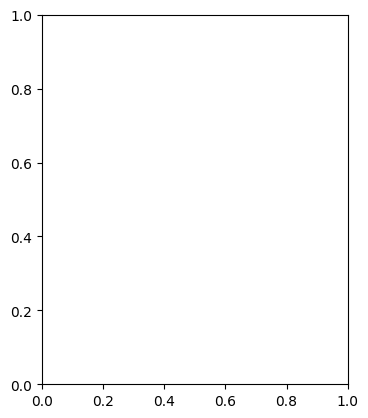

In [34]:
for gdf in lazarr:
    gdf.plot()

In [5]:
laz = laspy.read('ALS_data/N-34-120-D-c-2-1.laz')

In [6]:
arr = []
for i in range(len(laz)):
    arr.append(Point(laz['x'][i], laz['y'][i]))
gdf = gpd.GeoDataFrame({'elevation': laz['z'], 'geometry': arr})
gdf.plot()

KeyboardInterrupt: 

### Plotting Graphs

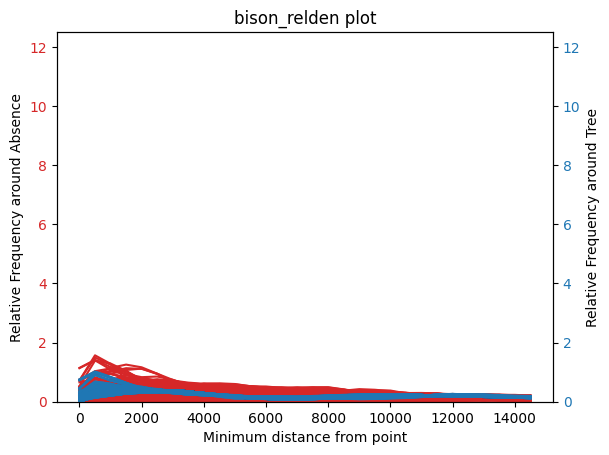

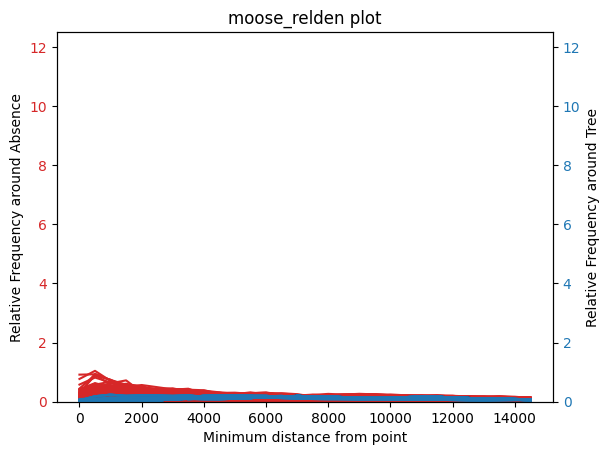

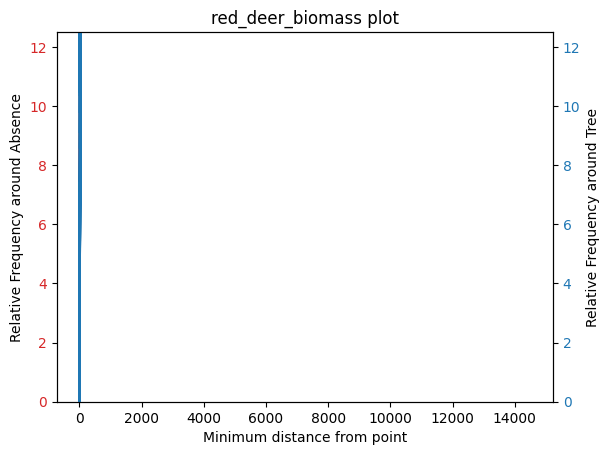

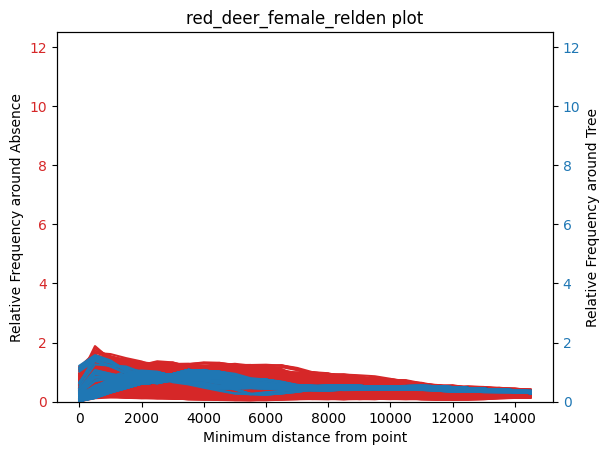

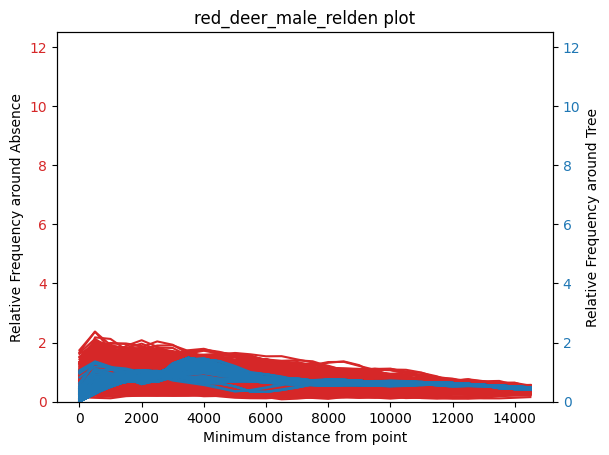

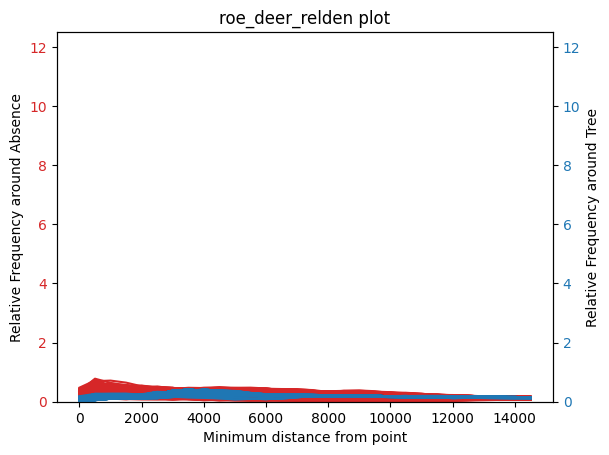

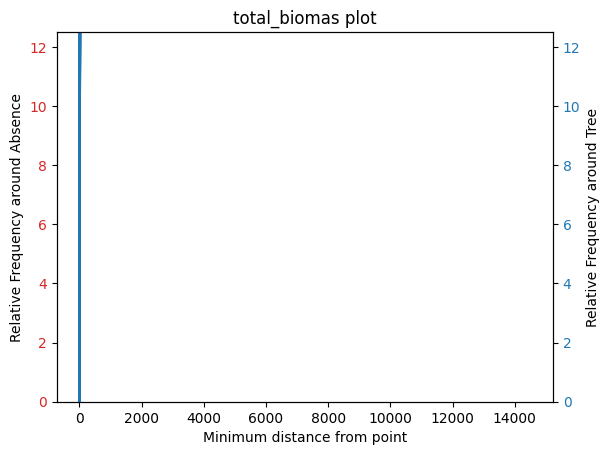

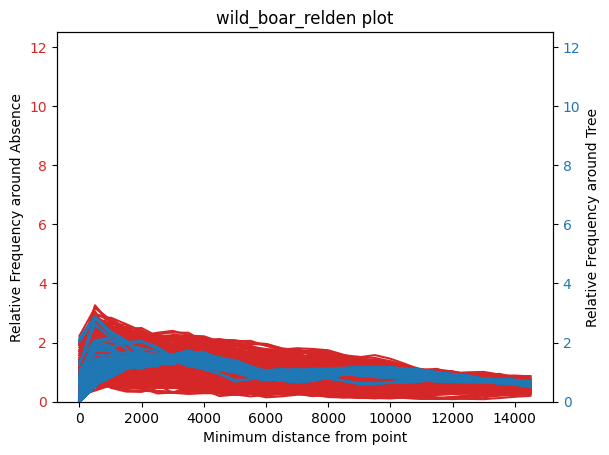

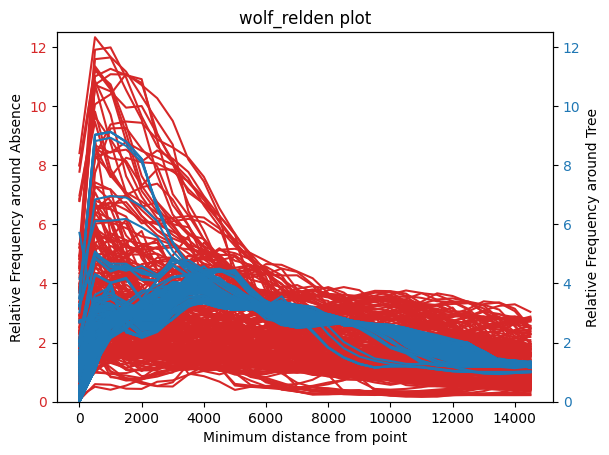

In [50]:
for file in os.listdir('frames/'):
    abdist = absencedists['absence_' + file[:-8] + '_dist']
    fig, ax1 = plt.subplots()
    for title in abdist:
        if 'Absence' in title:
            ax1.plot(abdist['Min Distance'], abdist[title], color = 'tab:red')
    ax1.tick_params(axis = 'y', labelcolor = 'tab:red')
    plt.title(file[:-8] + ' plot')
    ax1.set_xlabel('Minimum distance from point')
    ax1.set_ylabel('Relative Frequency around Absence')
    plt.ylim([0,12.5])
    treedist = dists['tree_' + file[:-8] + '_dist']
    ax2 = ax1.twinx()
    ax2.set_ylabel('Relative Frequency around Tree')
    for title in treedist:
        if 'Tree' in title:
            ax2.plot(treedist['Min Distance'], treedist[title], color = 'tab:blue')
    ax2.tick_params(axis = 'y', labelcolor = 'tab:blue')
    plt.ylim([0,12.5])
    plt.show()

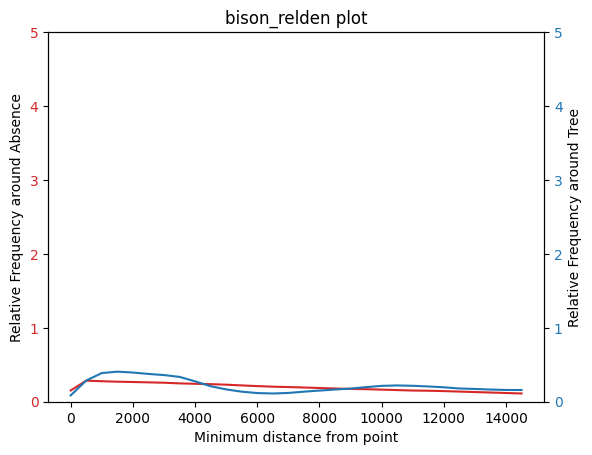

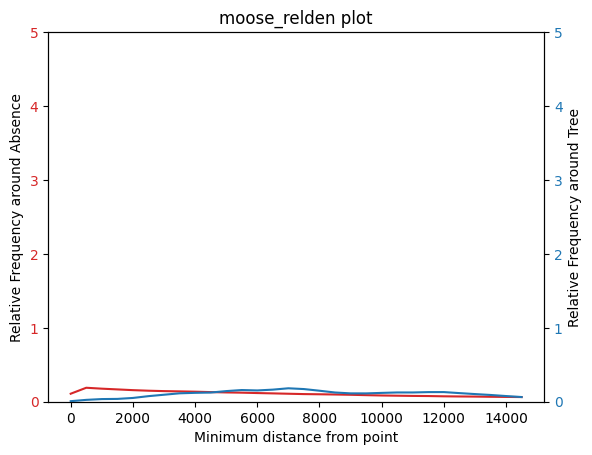

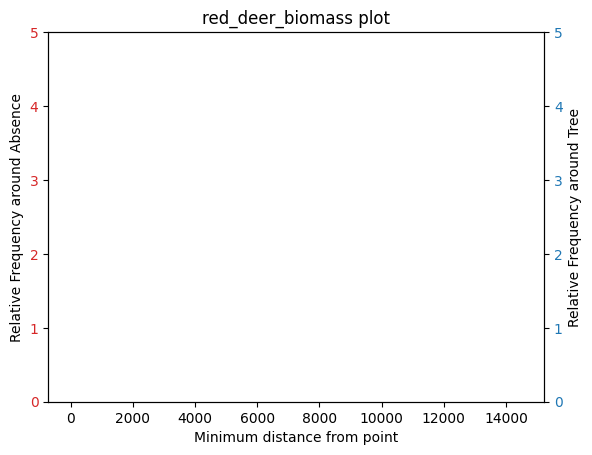

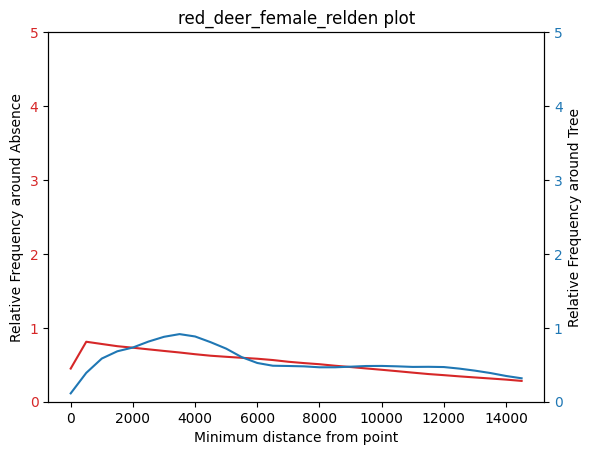

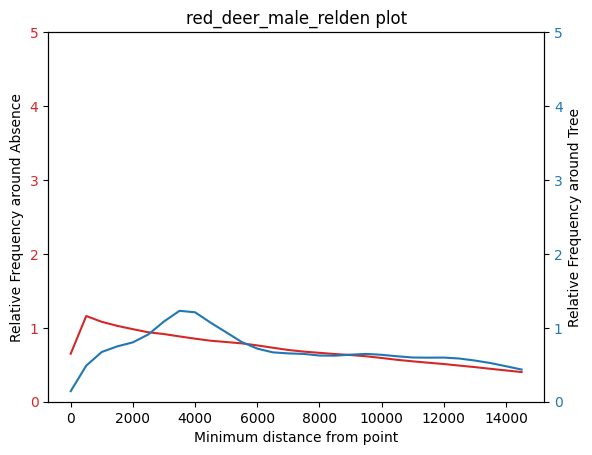

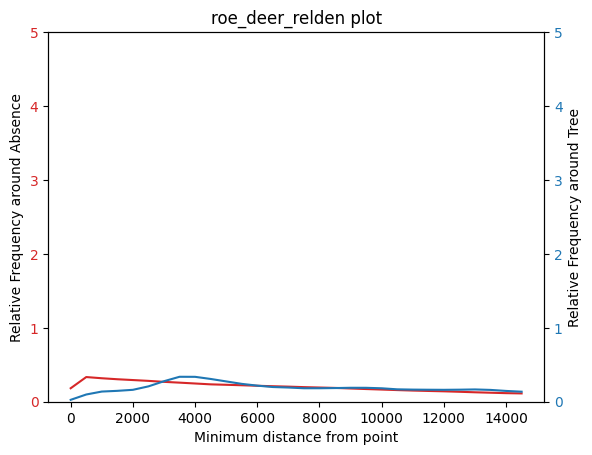

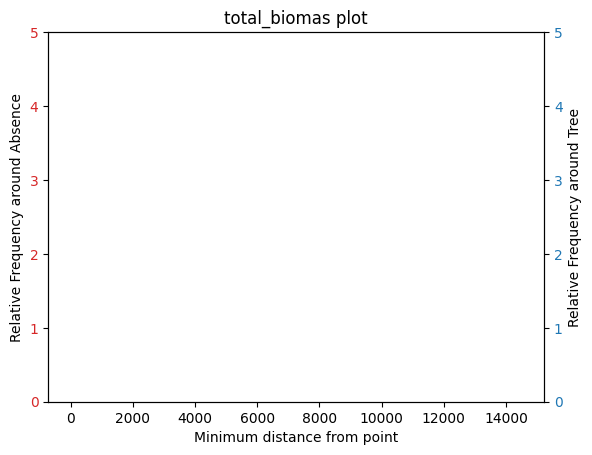

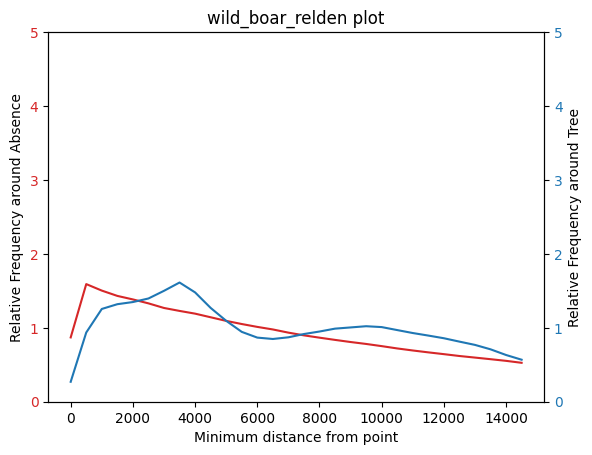

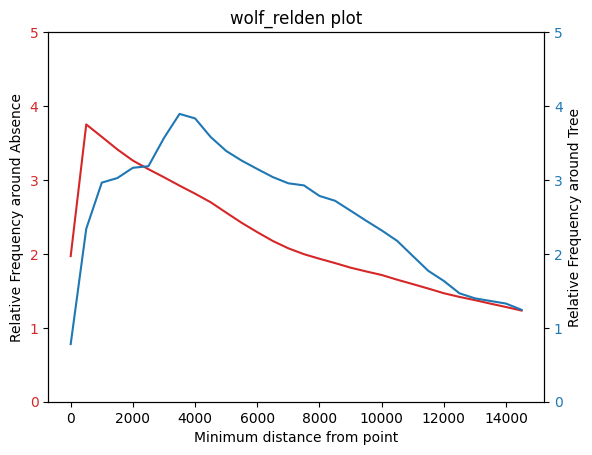

In [40]:
count = 0
for file in os.listdir('frames/'):
    abdist = absencedists['absence_' + file[:-8] + '_dist']
    fig, ax1 = plt.subplots()
    ax1.plot(abdist['Min Distance'], absencearrs[count], color = 'tab:red')
    ax1.tick_params(axis = 'y', labelcolor = 'tab:red')
    plt.title(file[:-8] + ' plot')
    ax1.set_xlabel('Minimum distance from point')
    ax1.set_ylabel('Relative Frequency around Absence')
    plt.ylim([0,5])
    treedist = dists['tree_' + file[:-8] + '_dist']
    ax2 = ax1.twinx()
    ax2.set_ylabel('Relative Frequency around Tree')
    ax2.plot(treedist['Min Distance'], treearrs[count], color = 'tab:blue')
    ax2.tick_params(axis = 'y', labelcolor = 'tab:blue')
    plt.ylim([0,5])
    plt.show()
    count = count + 1

In [9]:
for file in os.listdir('frames/'):
    ax = ungulates[file[:-8]].to_crs('EPSG:2180').plot(column = 'Scale')
    prunus.plot(ax = ax, color = 'red', markersize = .5)
    ax.set_title(file[:-8])

NameError: name 'ungulates' is not defined

# Testing Workspace

In [31]:
laz1 = laspy.read('ALS_data/N-34-120-D-a-4-2.laz')

In [3]:
arr = []
for i in range(len(laz1)):
    arr.append(Point(laz1['x'][i], laz1['y'][i]))
df = gpd.GeoDataFrame({'ele' : list(laz1['z']), 'geometry': arr})

In [4]:
df.crs = 'EPSG:2180'
df = df.to_crs('EPSG:4326')

In [5]:
lat = df['geometry'].x
long = df['geometry'].y
ele = df['ele']

In [9]:
df = pd.DataFrame({'lat' : lat, 'long' : long, 'ele' : ele})
df.to_csv('LidarData1.csv')

In [ ]:
Xs = []
Ys = []
Zs = []
for file in os.listdir('ALS_data/'):
    laz = laspy.read('ALS_data/' + file)
    Xs.extend(laz['x'])
    Ys.extend(laz['y'])
    Zs.extend(laz['z'])

In [74]:
arr = []
for i in range(len(laz1)):
    if laz1['z'][i] < 200:
        arr.append(Point(laz1['x'][i], laz1['y'][i]))

In [7]:
df = pd.read_csv('LidarData1.csv')
lat = df['lat']
long = df['long']
ele = df['ele']

In [26]:
points2 = np.array([lat[::200], long[::200], ele[::200]])

In [50]:
points

array([[ 23.84471913,  52.78335638, 148.09      ],
       [ 23.84472564,  52.7833562 , 148.44      ],
       [ 23.84473126,  52.78335597, 147.91      ],
       ...,
       [ 23.87112419,  52.7708342 , 150.81      ],
       [ 23.87110548,  52.77083407, 152.51      ],
       [ 23.87110207,  52.77083412, 151.5       ]])

In [51]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([geom])

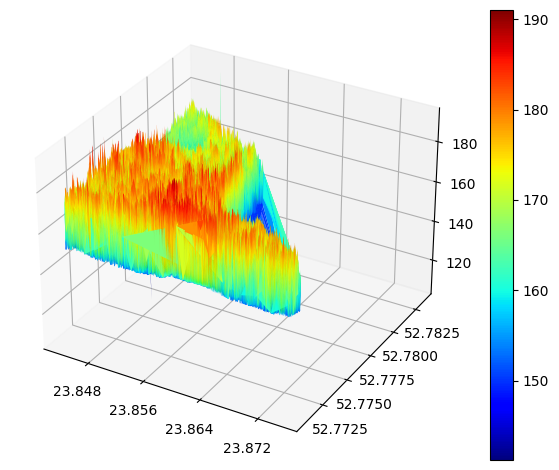

In [12]:
mpl.rcParams['path.simplify'] = True
mpl.style.use('fast')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#surf = ax.plot_trisurf(laz1['x'][::25], laz1['y'][::25], laz1['z'][::25], cmap=cm.jet, linewidth=0)
surf = ax.plot_trisurf(lat[::50], long[::50], ele[::50], cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.show()

In [3]:
# Set Downsampling Factor
downsampling_factor = 10000
# Set Chunk Size
chunk_size = 1000000
# Get the total number of points
num_points = len(long)
# Create empty arrays to store coordinates
x_values = np.empty(num_points)
y_values = np.empty(num_points)
z_values = np.empty(num_points)
# Read the data in chunks
for i in range(0, num_points, chunk_size):
    # Read the chunk of points
    end = min(i + chunk_size, num_points)
    pointsX = long[i:end]
    pointsY = lat[i:end]
    pointsZ = ele[i:end]
    # Extract the x, y, and z coordinates from the chunk
    x_values[i:end] = pointsX
    y_values[i:end] = pointsY
    z_values[i:end] = pointsZ
# Downsample the coordinates
x_values = x_values[::downsampling_factor]
y_values = y_values[::downsampling_factor]
z_values = z_values[::downsampling_factor]
# Create a 2D grid from the coordinates
x_grid, y_grid = np.meshgrid(np.unique(x_values), np.unique(y_values))
z_grid = np.zeros_like(x_grid)
# Populate the grid with z values
for i, j in np.ndindex(x_grid.shape):
    mask = np.logical_and(x_values == x_grid[i, j], y_values == y_grid[i, j])
    z_grid[i, j] = z_values[mask].mean()
# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis')
# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('LAZ Surface Map')
# Show the plot
plt.show()

NameError: name 'long' is not defined

In [72]:
list(laz1['z'])[0]

148.09

In [ ]:
# Adi experiment

In [9]:
from mayavi import mlab

In [10]:
mlab.init_notebook()

Notebook initialized with ipy backend.


In [44]:
print(ele)

0           148.09
1           148.44
2           147.91
3           147.97
4           148.28
             ...  
65314664    150.90
65314665    150.45
65314666    150.81
65314667    152.51
65314668    151.50
Name: ele, Length: 65314669, dtype: float64


In [11]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
mlab.clf()

mlab.axes(xlabel='lat', ylabel='lon')
mlab.outline()

mlab.view(-160, 125, 10)
mlab.roll(-90)

mlab.surf(lat, long, ele, extent=(23.84, 23.88, 52.77, 52.783, 148, 152))

No data: cannot use a Filter/Module/ModuleManager.
No data: cannot use a Filter/Module/ModuleManager.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

<ScaledArrayView([557421.92 557421.93 557421.93 ... 556151.14 556151.04 556151.03])>

### Opening TIFFs

In [8]:
im = Image.open('rasters/bison_relden.tif')
im.show()

UnidentifiedImageError: cannot identify image file 'rasters/bison_relden.tif'

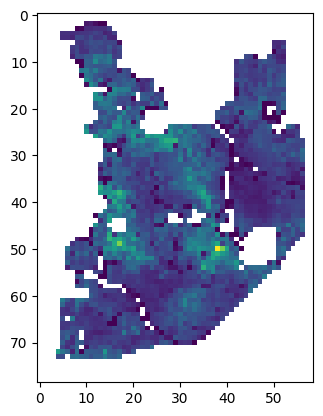

<Axes: >

In [39]:
bison = rasterio.open('rasters/roe_deer_relden.tif')
rasterio.plot.show(bison.read(1))

In [19]:
mask = bison.dataset_mask()
for geom, val in rasterio.features.shapes(
            mask, transform=bison.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            bison.crs, 'EPSG:4326', geom, precision=6)


In [14]:
arr = []
for i in range(len(bisondf)):
    arr.append(Point(bisondf['x'][i], bisondf['y'][i]))
bisongdf = gpd.GeoDataFrame(bisondf, geometry = arr, crs = 'EPSG:2810')

In [44]:
for file in os.listdir('rasters'):
    arggr = georasters.from_file('rasters/' + file)
    argdf = arggr.to_pandas()
    arr = []
    for i in range(len(argdf)):
        arr.append(Point(argdf['x'][i], argdf['y'][i]))
    arggdf = gpd.GeoDataFrame(argdf, geometry = arr, crs = 'EPSG: 2810')
    arggdf['Scale'] = arggdf[True]
    arggdf = arggdf.drop(True, axis = 1)
    arggdf.to_file('frames/' + file[:-4] + '.geojson', driver = 'GeoJSON')

In [36]:
bisongdf.to_file('frames/bisongdf.geojson', driver = 'GeoJSON')

In [26]:
bisongdf['Scale'] = bisongdf[True]

In [26]:
Prunus_trees = pd.read_excel('Glupka - koordynatypop_Patryk data.xlsx')

In [36]:
geos = []
for i in range(len(Prunus_trees)):
    geos.append(Point([Prunus_trees['lon'][i], Prunus_trees['lat'][i], Prunus_trees['ele'][i]]))

In [37]:
Prunus_trees['geometry'] = geos
gdf = gpd.GeoDataFrame(Prunus_trees, crs="EPSG:4326")

In [8]:
gdf = gdf.to_crs('EPSG:2180')

In [39]:
Prunus = gdf

In [14]:
# 3.10.9 Prev python version
# 3.7.16 New python version
import gdal

ModuleNotFoundError: No module named 'gdal'

In [12]:
species = ungulates[name].to_crs('EPSG:2180').copy()
species['Scale'] = sum(species['Scale'])/len(species['Scale'])

In [13]:
species

,row,col,x,y,Scale,geometry
0,2,10,809500.0,572500.0,4.233532,POINT (809500.000 572500.000)
1,2,11,810000.0,572500.0,4.233532,POINT (810000.000 572500.000)
2,2,12,810500.0,572500.0,4.233532,POINT (810500.000 572500.000)
3,2,13,811000.0,572500.0,4.233532,POINT (811000.000 572500.000)
4,2,14,811500.0,572500.0,4.233532,POINT (811500.000 572500.000)
...,...,...,...,...,...,...
2298,73,13,811000.0,537000.0,4.233532,POINT (811000.000 537000.000)
2299,73,14,811500.0,537000.0,4.233532,POINT (811500.000 537000.000)
2300,73,15,812000.0,537000.0,4.233532,POINT (812000.000 537000.000)
2301,73,16,812500.0,537000.0,4.233532,POINT (812500.000 537000.000)


In [19]:
name = os.listdir('frames/')[0][:-8]
species = dists[name]
df = pd.DataFrame({'Min Distance' : np.arange(0,15000,500), 'Max Distance' : np.arange(500,15500,500)})
for i in range(len(species)):
    df = pd.concat([df, pd.DataFrame({('Tree ' + (str)(i+1)) : species[i]})], axis = 1)
df

,Min Distance,Max Distance,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,...,Tree 250,Tree 251,Tree 252,Tree 253,Tree 254,Tree 255,Tree 256,Tree 257,Tree 258,Tree 259
0,0,500,0.038094,0.040163,0.039599,0.047882,0.048602,0.045921,0.043650,0.042926,...,0.730173,0.734351,0.759373,0.424295,0.099320,0.095513,0.095628,0.095959,0.095498,0.096354
1,500,1000,0.204334,0.208090,0.210589,0.222566,0.223603,0.222269,0.219703,0.218920,...,0.983493,1.002074,1.024566,1.000322,0.237425,0.235783,0.235845,0.236091,0.235873,0.236290
2,1000,1500,0.315036,0.324398,0.331744,0.345989,0.347154,0.348131,0.348496,0.351520,...,0.808686,0.823808,0.844561,0.812767,0.331714,0.330976,0.331035,0.331401,0.331259,0.331558
3,1500,2000,0.369040,0.372703,0.375487,0.381522,0.382027,0.382638,0.383503,0.385873,...,0.634287,0.636832,0.640886,0.633904,0.378101,0.377716,0.377741,0.377886,0.377820,0.377956
4,2000,2500,0.364052,0.365935,0.367523,0.369623,0.369789,0.370295,0.371208,0.373426,...,0.486229,0.443032,0.429573,0.413815,0.363716,0.363754,0.363760,0.363817,0.363811,0.363829
5,2500,3000,0.371217,0.374574,0.377939,0.380812,0.381057,0.382774,0.384531,0.386451,...,0.332287,0.331496,0.329954,0.334963,0.361149,0.361684,0.361682,0.361758,0.361802,0.361734
6,3000,3500,0.386316,0.384418,0.382809,0.379657,0.379381,0.378985,0.378646,0.377560,...,0.283451,0.291337,0.289670,0.298805,0.384157,0.384245,0.384235,0.384162,0.384184,0.384136
7,3500,4000,0.357295,0.357373,0.357322,0.357184,0.357163,0.357068,0.356970,0.356911,...,0.243719,0.241887,0.241782,0.242910,0.356525,0.356605,0.356604,0.356609,0.356617,0.356605
8,4000,4500,0.279984,0.279839,0.279675,0.280302,0.280363,0.280160,0.279852,0.279577,...,0.216727,0.218453,0.217786,0.219245,0.283631,0.283443,0.283446,0.283446,0.283426,0.283461
9,4500,5000,0.209688,0.208462,0.207378,0.205492,0.205331,0.205007,0.204661,0.203912,...,0.207798,0.207288,0.202645,0.211474,0.209022,0.209033,0.209027,0.208984,0.208993,0.208972


In [20]:
dists[name]

[[0.03809362301856582,
  0.20433350900639977,
  0.31503553074073976,
  0.36903997195573546,
  0.36405198669675587,
  0.3712170777801649,
  0.38631584441482175,
  0.35729539491212814,
  0.2799840531055761,
  0.209687618478398,
  0.16071185584943096,
  0.14660242705708726,
  0.1251069430355054,
  0.11528026213252038,
  0.12558420560413225,
  0.13704016048075263,
  0.1523578833248596,
  0.1678302613288362,
  0.17944236497004523,
  0.2035521347563261,
  0.23026440968646295,
  0.23276100213218065,
  0.2234641281218431,
  0.20974909534098532,
  0.19381236890441297,
  0.1733710578439239,
  0.1705726085614762,
  0.150327095907074,
  0.1545945546685579,
  0.15467576662086746],
 [0.040163186909536755,
  0.20809026167131356,
  0.32439825761099206,
  0.37270258011460655,
  0.3659347292559222,
  0.3745737142685498,
  0.3844184999263545,
  0.3573729833799132,
  0.2798386887549401,
  0.20846238872347997,
  0.16112629346180757,
  0.14526353235836575,
  0.12358796348775417,
  0.11394418614031984,
  0.1

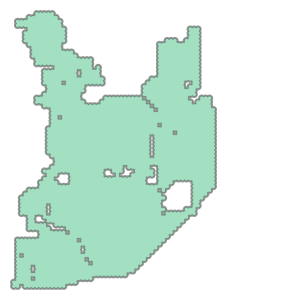

In [35]:
species = ungulates[name].to_crs('EPSG:2180')
mpoint = MultiPoint(species['geometry'])
mpoint.buffer(250 * math.sqrt(2))

In [10]:
for i in absencedists[file[:-8]]:
    print(i)

Unnamed: 0
Min Distance
Max Distance
Absence 1
Absence 2
Absence 3
Absence 4
Absence 5
Absence 6
Absence 7
Absence 8
Absence 9
Absence 10
Absence 11
Absence 12
Absence 13
Absence 14
Absence 15
Absence 16
Absence 17
Absence 18
Absence 19
Absence 20
Absence 21
Absence 22
Absence 23
Absence 24
Absence 25
Absence 26
Absence 27
Absence 28
Absence 29
Absence 30
Absence 31
Absence 32
Absence 33
Absence 34
Absence 35
Absence 36
Absence 37
Absence 38
Absence 39
Absence 40
Absence 41
Absence 42
Absence 43
Absence 44
Absence 45
Absence 46
Absence 47
Absence 48
Absence 49
Absence 50
Absence 51
Absence 52
Absence 53
Absence 54
Absence 55
Absence 56
Absence 57
Absence 58
Absence 59
Absence 60
Absence 61
Absence 62
Absence 63
Absence 64
Absence 65
Absence 66
Absence 67
Absence 68
Absence 69
Absence 70
Absence 71
Absence 72
Absence 73
Absence 74
Absence 75
Absence 76
Absence 77
Absence 78
Absence 79
Absence 80
Absence 81
Absence 82
Absence 83
Absence 84
Absence 85
Absence 86
Absence 87
Absence 88
Abse

In [49]:
dists['tree_bison_relden_dist']

,Unnamed: 0,Min Distance,Max Distance,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,...,Tree 250,Tree 251,Tree 252,Tree 253,Tree 254,Tree 255,Tree 256,Tree 257,Tree 258,Tree 259
0,0,0,500,0.038094,0.040163,0.039599,0.047882,0.048602,0.045921,0.043650,...,0.730173,0.734351,0.759373,0.424295,0.099320,0.095513,0.095628,0.095959,0.095498,0.096354
1,1,500,1000,0.204334,0.208090,0.210589,0.222566,0.223603,0.222269,0.219703,...,0.983493,1.002074,1.024566,1.000322,0.237425,0.235783,0.235845,0.236091,0.235873,0.236290
2,2,1000,1500,0.315036,0.324398,0.331744,0.345989,0.347154,0.348131,0.348496,...,0.808686,0.823808,0.844561,0.812767,0.331714,0.330976,0.331035,0.331401,0.331259,0.331558
3,3,1500,2000,0.369040,0.372703,0.375487,0.381522,0.382027,0.382638,0.383503,...,0.634287,0.636832,0.640886,0.633904,0.378101,0.377716,0.377741,0.377886,0.377820,0.377956
4,4,2000,2500,0.364052,0.365935,0.367523,0.369623,0.369789,0.370295,0.371208,...,0.486229,0.443032,0.429573,0.413815,0.363716,0.363754,0.363760,0.363817,0.363811,0.363829
5,5,2500,3000,0.371217,0.374574,0.377939,0.380812,0.381057,0.382774,0.384531,...,0.332287,0.331496,0.329954,0.334963,0.361149,0.361684,0.361682,0.361758,0.361802,0.361734
6,6,3000,3500,0.386316,0.384418,0.382809,0.379657,0.379381,0.378985,0.378646,...,0.283451,0.291337,0.289670,0.298805,0.384157,0.384245,0.384235,0.384162,0.384184,0.384136
7,7,3500,4000,0.357295,0.357373,0.357322,0.357184,0.357163,0.357068,0.356970,...,0.243719,0.241887,0.241782,0.242910,0.356525,0.356605,0.356604,0.356609,0.356617,0.356605
8,8,4000,4500,0.279984,0.279839,0.279675,0.280302,0.280363,0.280160,0.279852,...,0.216727,0.218453,0.217786,0.219245,0.283631,0.283443,0.283446,0.283446,0.283426,0.283461
9,9,4500,5000,0.209688,0.208462,0.207378,0.205492,0.205331,0.205007,0.204661,...,0.207798,0.207288,0.202645,0.211474,0.209022,0.209033,0.209027,0.208984,0.208993,0.208972


In [50]:
absencedists['absence_bison_relden_dist']

,Unnamed: 0,Min Distance,Max Distance,Absence 1,Absence 2,Absence 3,Absence 4,Absence 5,Absence 6,Absence 7,...,Absence 250,Absence 251,Absence 252,Absence 253,Absence 254,Absence 255,Absence 256,Absence 257,Absence 258,Absence 259
0,0,0,500,0.038094,0.040163,0.039599,0.047882,0.048602,0.045921,0.043650,...,0.730173,0.734351,0.759373,0.424295,0.099320,0.095513,0.095628,0.095959,0.095498,0.096354
1,1,500,1000,0.204334,0.208090,0.210589,0.222566,0.223603,0.222269,0.219703,...,0.983493,1.002074,1.024566,1.000322,0.237425,0.235783,0.235845,0.236091,0.235873,0.236290
2,2,1000,1500,0.315036,0.324398,0.331744,0.345989,0.347154,0.348131,0.348496,...,0.808686,0.823808,0.844561,0.812767,0.331714,0.330976,0.331035,0.331401,0.331259,0.331558
3,3,1500,2000,0.369040,0.372703,0.375487,0.381522,0.382027,0.382638,0.383503,...,0.634287,0.636832,0.640886,0.633904,0.378101,0.377716,0.377741,0.377886,0.377820,0.377956
4,4,2000,2500,0.364052,0.365935,0.367523,0.369623,0.369789,0.370295,0.371208,...,0.486229,0.443032,0.429573,0.413815,0.363716,0.363754,0.363760,0.363817,0.363811,0.363829
5,5,2500,3000,0.371217,0.374574,0.377939,0.380812,0.381057,0.382774,0.384531,...,0.332287,0.331496,0.329954,0.334963,0.361149,0.361684,0.361682,0.361758,0.361802,0.361734
6,6,3000,3500,0.386316,0.384418,0.382809,0.379657,0.379381,0.378985,0.378646,...,0.283451,0.291337,0.289670,0.298805,0.384157,0.384245,0.384235,0.384162,0.384184,0.384136
7,7,3500,4000,0.357295,0.357373,0.357322,0.357184,0.357163,0.357068,0.356970,...,0.243719,0.241887,0.241782,0.242910,0.356525,0.356605,0.356604,0.356609,0.356617,0.356605
8,8,4000,4500,0.279984,0.279839,0.279675,0.280302,0.280363,0.280160,0.279852,...,0.216727,0.218453,0.217786,0.219245,0.283631,0.283443,0.283446,0.283446,0.283426,0.283461
9,9,4500,5000,0.209688,0.208462,0.207378,0.205492,0.205331,0.205007,0.204661,...,0.207798,0.207288,0.202645,0.211474,0.209022,0.209033,0.209027,0.208984,0.208993,0.208972


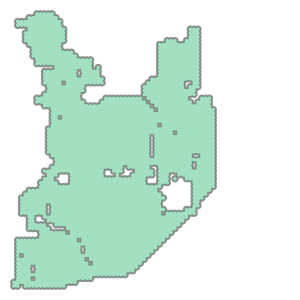

In [55]:
species = ungulates[name].to_crs('EPSG:2180')
mpoint = MultiPoint(species['geometry']).difference(MultiPoint(prunus.to_crs('EPSG:2180')['geometry']).buffer(250 * math.sqrt(2)))
mpoint.buffer(250 * math.sqrt(2))

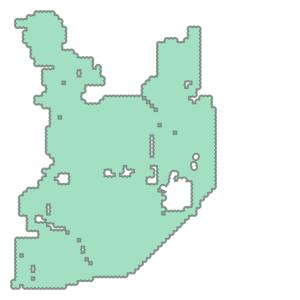

In [58]:
MultiPoint(species['geometry']).buffer(250 * math.sqrt(2)).difference(MultiPoint(prunus.to_crs('EPSG:2180')['geometry']).buffer(250 * math.sqrt(2)))